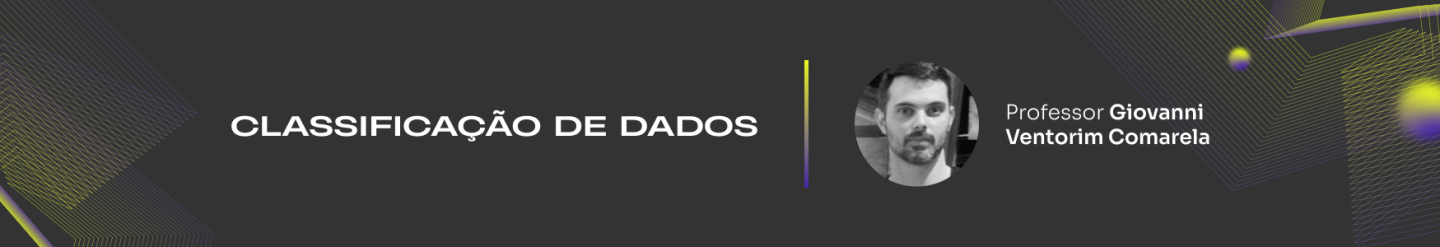

# Desafios e Armadilhas em Classificação

Diferentemente das aulas passadas, na aula de hoje (e nessa semana), não veremos novos classificadores.

Ao invés disso, vamos estudar aspectos experimentais importantes para evitar "armadilhas" comuns.

Para começar, vamos relembrar o nosso problema de interesse.

## Nosso problema de interesse

Dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$, a tarefa de classificação consiste em encontrar um modelo $f$ que aprenda dos vetores de características os rótulos.

Há dois requisitos principais:

1. Se $(\mathbf{x}, y) \in D$, então $f(\mathbf{x}) = y$ com alta probabilidade.

2. A função aprendida deve ser **generalizável**. Se um novo $\mathbf{x}$ não pertencente ao conjunto $D$ for observado, deseja-se também que $f(\mathbf{x})$ seja o rótulo correto de $\mathbf{x}$ com alta probabilidade.

## Objetivos da aula

Por hoje, veremos alguns exemplos de armadilhas que podemos cair quando estamos treinando ou avaliando um classificador. Em especial, veremos que:

1. Avaliar um classificador com apenas uma métrica (e.g., acurácia) pode nos levar a **falsos** resultados bons!

2. Escolhas ruins, de hiperparâmetros ou procedimentos experimentais, durante o treinamento do modelo podem resultar em modelos não **generalizáveis**. Em outras palavras, modelos com boa taxa de acerto no conjunto de treinamento, mas muito ruins para dados novos.

Nas próximas aulas, veremos como esses desafios e armadilhas podem ser contornados.

## Armadilha I - Confiar apenas na acurácia

Para esse exemplo, vamos utilizar um conjunto de dados sintético.

In [ ]:
#@title Criação do Conjunto de Dados

import pandas as pd
from sklearn.datasets import make_classification

# criando um conjunto de dados extremamente desbalanceado
X, y = make_classification(n_samples = 1000, n_features = 5, n_classes = 2,
                           weights = [0.05, 0.95], random_state = 10)

df = pd.DataFrame(X, columns = ['Característica ' + str(i) for i in range(X.shape[1])])
df['Rótulo'] = y

O conjunto de dados possui 5 características. Os rótulos (ou classes) de cada um dos objetos é representado pela coluna ``Rótulo``.

In [ ]:
df.head()

,Característica 0,Característica 1,Característica 2,Característica 3,Característica 4,Rótulo
0,-0.216903,1.180622,0.531222,0.939646,-1.591588,1
1,1.037688,0.563244,-0.231997,-2.134521,1.322167,1
2,-0.070230,1.751403,0.681047,0.824625,-2.166129,0
3,0.602699,0.914540,0.083651,-1.016489,1.614958,1
4,-0.325737,1.917986,0.851671,1.466230,-0.414004,1


Abaixo, é definido um classificador simples (``SimpleClassifier``). A maneira como esse classificador funciona não é importante por agora.

In [ ]:
#@title Definição do Classificador
import numpy as np

# definindo um classificador simples que simplesmente associa todos
# os elementos a serem classificados com pertencentes à classe 1.
class SimpleClassifier():
  def __init__(self):
     pass

  def fit(self, X, y):
    pass

  def predict(self, X):
    return np.array([1] * X.shape[0])

Com isso, podemos seguir o procedimento de treinamento e avaliação visto nas aulas passadas! Incluindo:
- Divisão do conjunto de dados em subconjuntos para treinamento e teste;
- Transformação dos dados por reescala;
- Treinamento do classificador;
- Uso do classificador no conjunto de teste;
- Cômputo da acurácia do classificador.

Nesse momento, você já deve estar acostumando com essa sequência!

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# obtendo os dados
X = df.drop('Rótulo', axis = 1)
y = df['Rótulo']

# devidindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

# Aplicando transformação por reescala
scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

# Ajustando o modelo
model = SimpleClassifier()
model.fit(X_train_scaled, y_train);

# Aplicando a mesma transformação nos dados de teste
X_test_scaled = scaler.transform(X_test)

# Realizando a previsão para os dados de teste
y_pred = model.predict(X_test_scaled);

# Medindo a acurácia do modelo nos dados de teste
acc = accuracy_score(y_test, y_pred)
print("Acurácia do Classificador = %f" % acc)

Acurácia do Classificador = 0.956667


Com o resultado encontrado acima, podemos perceber que o ``SimpleClassifier`` é um classificador adequado para o conjunto de dados gerado! **Isso é verdade, uma vez que a acurácia obtida é significativamente alta!**

**Será que isso é verdade mesmo?**

Vamos analisar com mais calma o que está acontecendo!

Primeiro, se você observar a definição do ``SimpleClassifier``, verá que o método ``fit`` não realiza nenhuma operação. **Já o método ``predict``, retorna a classe 1 para TODOS os elementos do conjunto de teste**.

Como que um classificador tão simples e ingênuo pode funcionar tão bem?

O segredo está no conjunto de dados sendo utilizado. O conjunto de dados é significativamente **desbalanceado**. Isso significa que uma das classes ocorre consideravelmente mais do que a outra.

Veja:

In [ ]:
y.mean()

0.943

Mais especificamente, aproximadamente 95% dos objetos do conjunto de dados são pertencentes à classe 1.

Ou seja, um classificador que simplesmente "chuta" a classe 1 para todos tem uma excelente acurácia. No entanto, caso o custo de um **falso positivo** seja muito alto, pode-se perceber que esse classificador é, na verdade, muito ruim!

Esse exemplo mostra que usar apenas a acurácia como métrica de avaliação de classificadores não é uma abordagem adequada.

Nas próximas aulas, veremos várias outras métricas para sanar esse problema.


## Armadilha II - *Overfitting*

A segunda "armadilha" comum quando fazemos o treinamento de um classificador é o sobreajuste (ou, em inglês, *overfitting*).

O fenômeno de *overfitting* ocorre quando um classificador foi treinado de forma a explicar **tão bem** o conjunto de treinamento, que perde poder para **generalizar** para dados que não estiverem nesse conjunto.

Informalmente, é como se o modelo "decorasse" o conjunto de treinamento e não "soubesse o que fazer" com novos dados.

## Exemplo - Visualizando *overfitting* com o KNN

Nesse exemplo, vamos inspecionar como as regiões de decisão do KNN mudam quando mudamos o valor de $k$.

Para isso, considere o exemplo de problema de classificação abaixo. Esse exemplo já foi apresentado quando vimos o classificador KNN. Relembrando, há duas características e três classes.

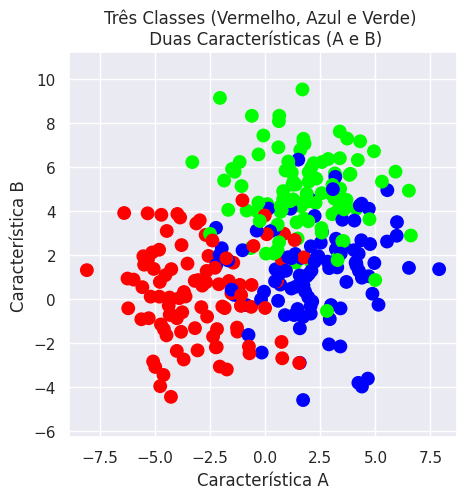

In [ ]:
#@title Conjunto de Dados
import sklearn.datasets as sk_data
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set()

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

X, y = sk_data.make_blobs(n_samples=300,
                          centers=[[-3, 0],[2, 5], [2.5, 1.5]],
                          #centers=[[-2, 0],[1, 5], [2.5, 1.5]],
                          cluster_std = [2, 2, 2],
                          #cluster_std = [2, 2, 2],
                          n_features=2,
                          center_box=(-10.0, 10.0),random_state=0)
plt.figure(figsize = (5,5))
plt.axis('equal')
plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold, s = 80);

plt.xlabel('Característica A')
plt.ylabel('Característica B')
plt.title('Três Classes (Vermelho, Azul e Verde) \n Duas Características (A e B)');

Vamos treinar o KNN nos dados acima para alguns valores distintos de $k$. As **regiões de decisão** são apresentadas abaixo.

Nas figuras, pontos a serem classificados que estiverem na região azul, serão classificados como pertencente à classe ``Azul``. O mesmo vale para as cores Vermelha e Verde.

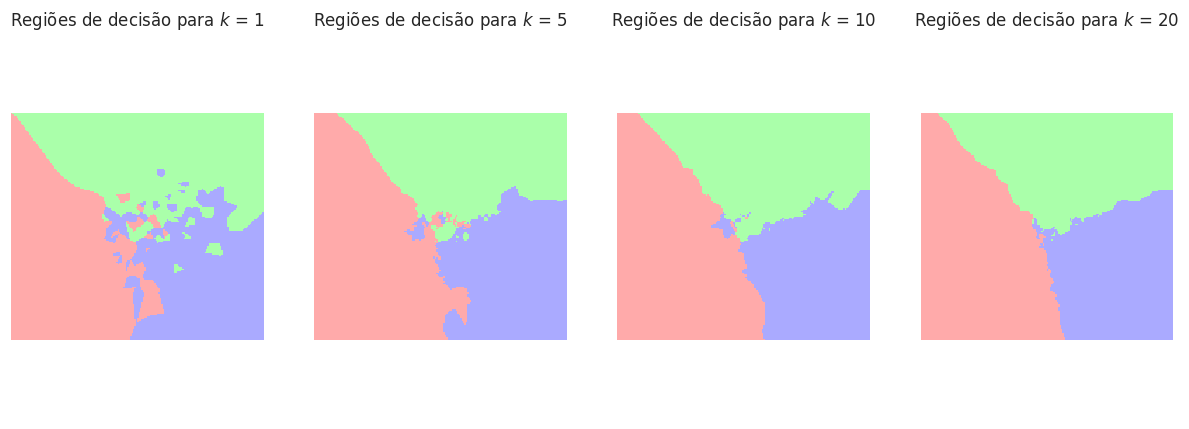

In [ ]:
#@title Regiões de Decisão para diferentes valores de $k$
from sklearn.neighbors import KNeighborsClassifier


h = .1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

f, axs = plt.subplots(1, 4, figsize=(15, 5))
for i, k in enumerate([1, 5, 10, 20]):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X, y)
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axs[i].pcolormesh(xx, yy, Z, cmap = cmap_light, shading = 'auto')
    axs[i].axis('equal')
    axs[i].axis('off')
    axs[i].set_title(f'Regiões de decisão para $k$ = {k}');

Veja que para valores pequenos de $k$, especialmente para $k = 1$, as regiões de decisão ficaram "fragmentadas". Ou seja, o classificador treinado, simplesmente "decorou" o conjunto de dados.

Vamos ver o que acontece com a acurácia do classificador, nesse conjunto de dados, para diferentes valores de $k$.

Primeiro, vamos dividir os dados em porções de treino e teste.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,
                                                    random_state = 7)

A função abaixo encapsula as boas práticas de treinamento do KNN que vimos em aulas passadas:
- Definição da transformação por reescala
- Treinamento do classificador no conjunto de treinamento
- Transformação dos dados do conjunto de teste
- Aplicação do classificador treinado no conjunto de teste
- Cálculo da acurácia

Para fins de comparação, o classificador também foi utilizado para prever os rótulos do conjunto de treinamento.

In [ ]:
def evaluate_knn(k, X_train, X_test, y_train, y_test):
  scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))
  scaler.fit(X_train)
  X_train_scaled = scaler.transform(X_train)

  model = KNeighborsClassifier(n_neighbors = k)
  model.fit(X_train_scaled, y_train);

  X_test_scaled = scaler.transform(X_test)
  y_pred_test = model.predict(X_test_scaled)

  y_pred_train = model.predict(X_train_scaled)

  return accuracy_score(y_test, y_pred_test), accuracy_score(y_train, y_pred_train)

A seguir, são computadas as acurácias nos conjuntos de treinamento e teste para diferentes valores de $k$.

In [ ]:
k_values = list(range(1, 26))
acc_test, acc_train = zip(*[evaluate_knn(k, X_train, X_test, y_train, y_test) for k in k_values])

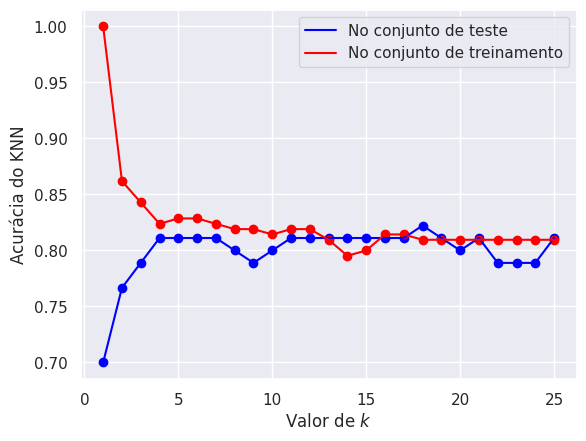

In [ ]:
#@title Comparação das Acurácias do KNN
import matplotlib.pyplot as plt

plt.scatter(k_values, acc_test, color = 'blue');
plt.plot(k_values, acc_test, color = 'blue', label = 'No conjunto de teste');
plt.scatter(k_values, acc_train, color = 'red');
plt.plot(k_values, acc_train, color = 'red', label = 'No conjunto de treinamento');
plt.xlabel(r'Valor de $k$')
plt.ylabel('Acurácia do KNN')
plt.legend(loc = 'best');

A Figura acima ilustra um cenário clássico de *overfitting*.

Para valores pequenos de $k$, o classificador treinado tem **excelente desempenho no conjunto de treinamento**. No entanto, **é incapaz de generalizar bem para o conjunto de teste** (objetos não vistos no treinamento).

O problema de *overfitting* é sério e não deve ser negligenciado!

Felizmente, há boas práticas em aprendizado de máquina que nos mostram como evitá-lo. Veremos isso nas próximas aulas!

Do mais, fica claro o motivo de não podermos treinar e avaliar um classificador no mesmo conjunto e dados. Se fizermos isso, com alta probabilidade, estaremos gerando *overfitting*.

## Exemplo - Visualizando *overfitting* com Árvores de Decisão


Agora, vamos visualizar o fenômeno de *overfitting* nesse mesmo conjunto de dados, mas utilizando uma Árvore de Decisão.

Primeiro, vamos construir uma árvore sem restrições. O resultado, apresentado abaixo, mostra que é um modelo grande e complexo.

In [ ]:
import sklearn.tree as tree

dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train);

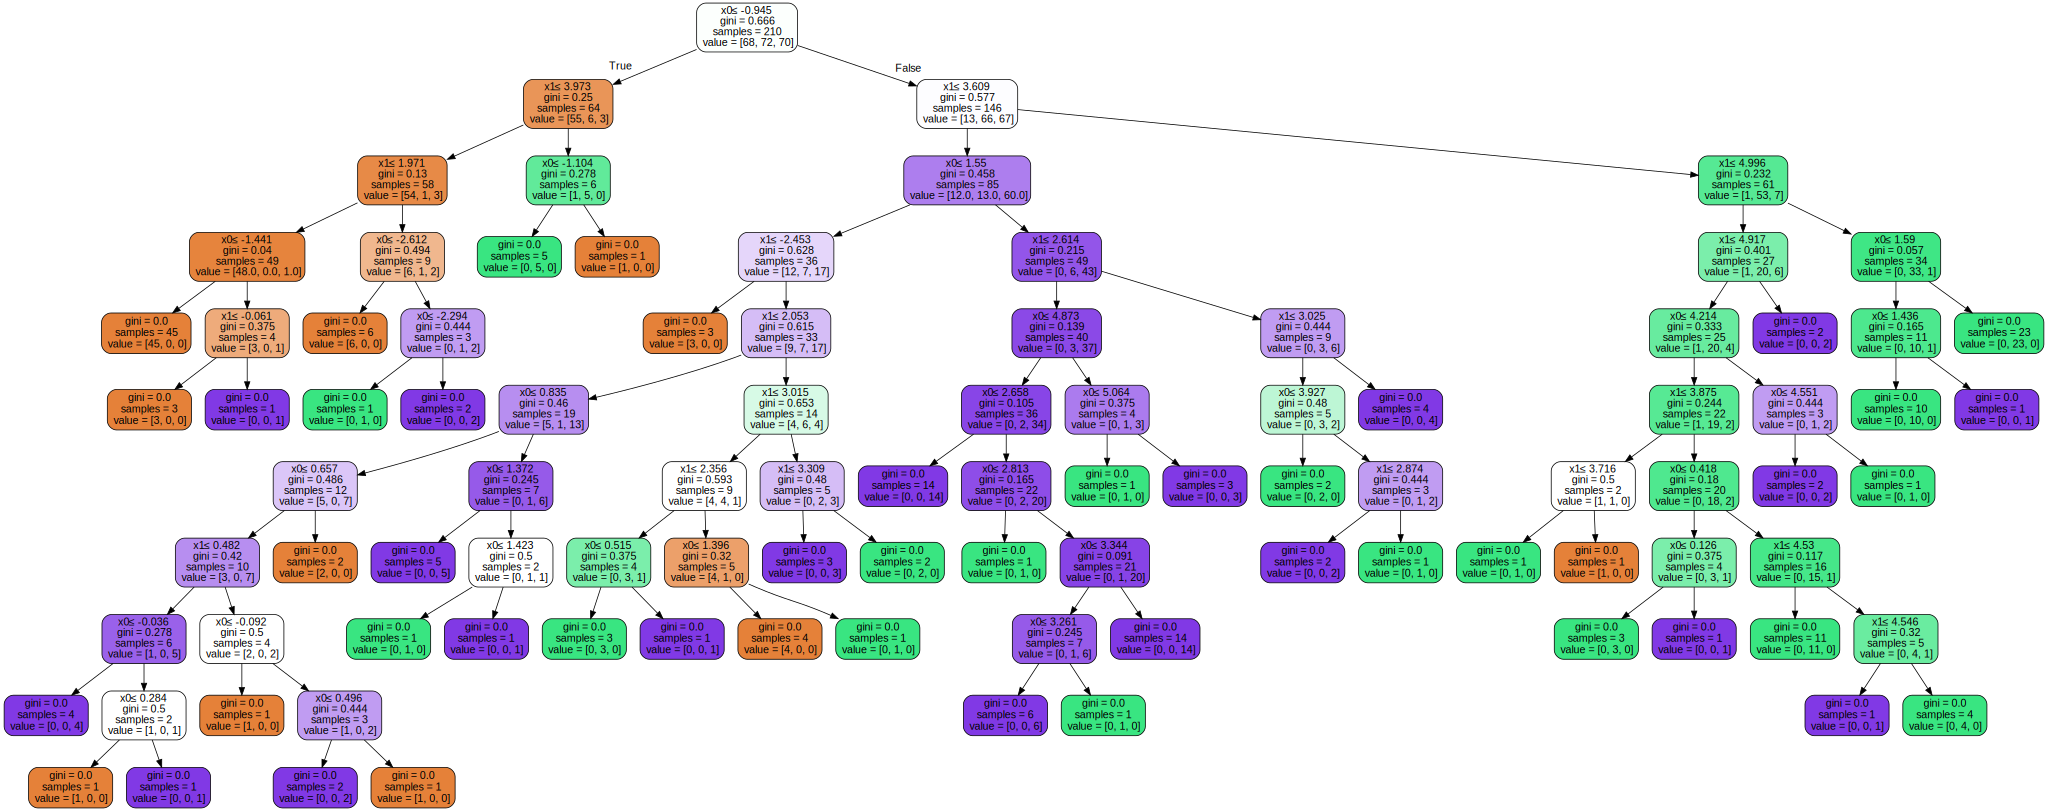

In [ ]:
#@title Árvore de Decisão para o conjunto de dados do exemplo anterior
import graphviz
import pydotplus

dot_data = tree.export_graphviz(dtc, out_file=None,
                     filled=True, rounded=True,
                     special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("dt-vis",view = True)
graph

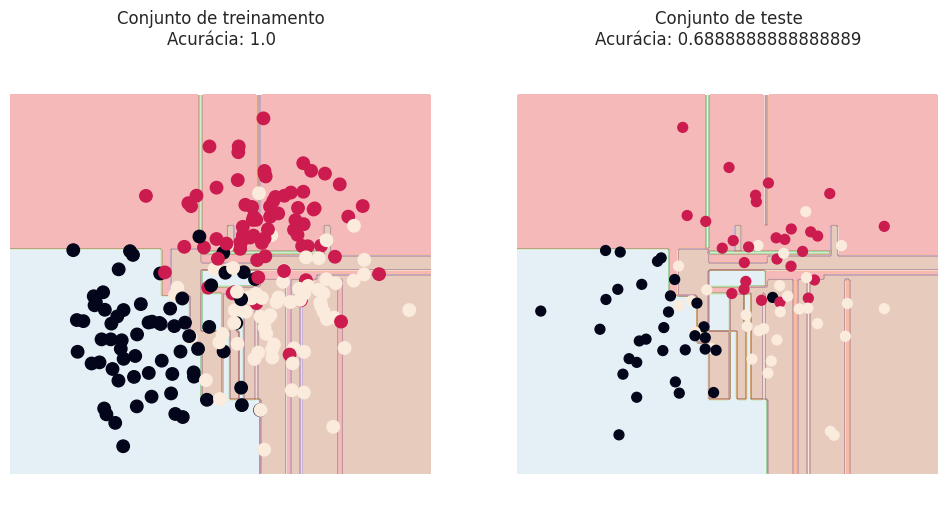

In [ ]:
#@title Regiões de Decisão e desempenho do classificador nos conjuntos de treinamento e teste
Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 80)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'Conjunto de treinamento\nAcurácia: {dtc.score(X_train, y_train)}');

plt.subplot(1, 2, 2)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, s = 50)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'Conjunto de teste\nAcurácia: {dtc.score(X_test, y_test)}');


Pode-se perceber, que o modelo treinado é especializado para o conjunto de treinamento, não conseguindo se adaptar a dados do conjunto de teste. Novamente, isso ilustra o fenômeno de *overfitting*.

Vamos agora restringir a complexidade do modelo. Para isso, usaremos o hiperparâmetro ``min_samples_leaf``, para informar que as folhas da árvore devem ter ao menos 10 objetos do conjunto de treinamento.

In [ ]:
dtc = tree.DecisionTreeClassifier(min_samples_leaf = 10)
dtc.fit(X_train, y_train);

Abaixo, pode-se perceber que o Árvore gerada é consideravelmente menor.

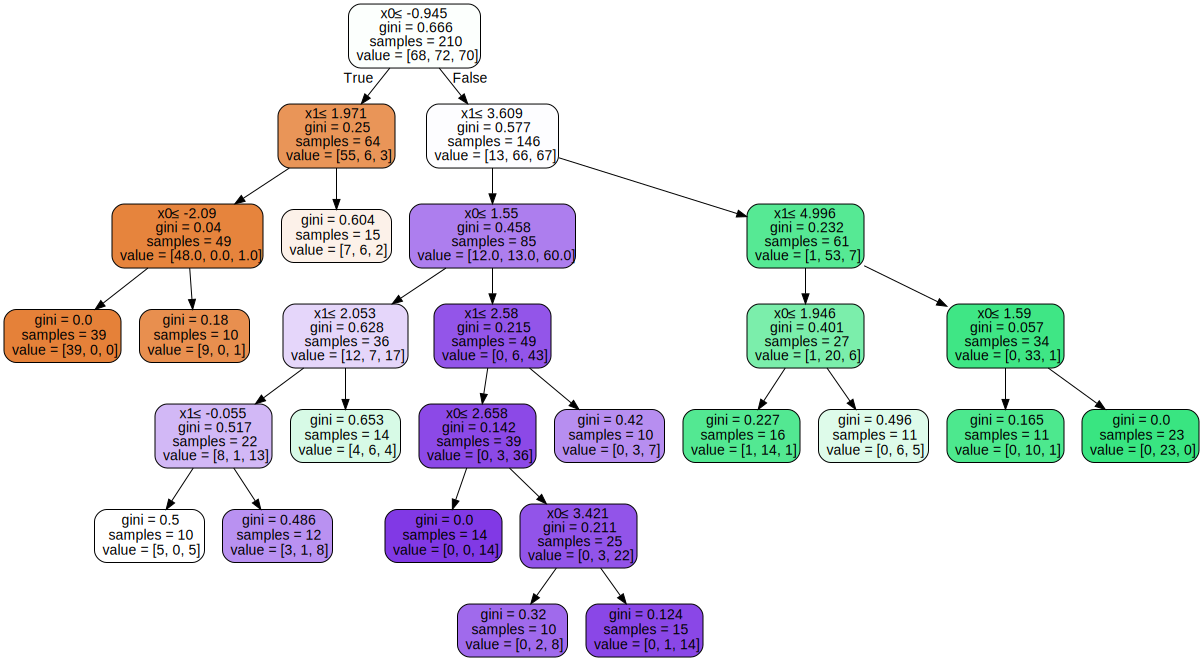

In [ ]:
#@title Árvore de Decisão para o conjunto de dados do exemplo anterior
import graphviz
import pydotplus

dot_data = tree.export_graphviz(dtc, out_file=None,
                     filled=True, rounded=True,
                     special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("dt-vis",view = True)
graph

Qual o impacto dessa mudança no desempenho do classificador?

Veja que o desempenho do classificador melhora significativamente no conjunto de teste!

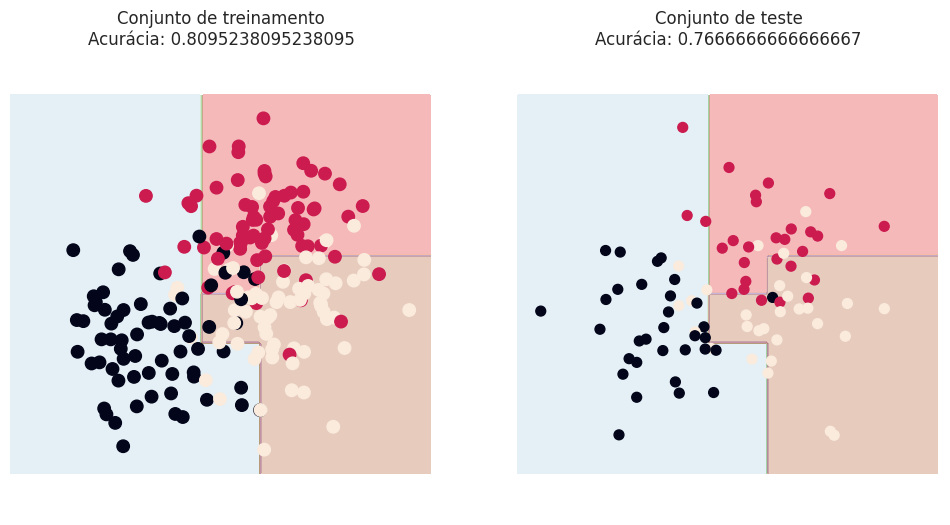

In [ ]:
#@title Regiões de Decisão e desempenho do classificador nos conjuntos de treinamento e teste
Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 80)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'Conjunto de treinamento\nAcurácia: {dtc.score(X_train, y_train)}');

plt.subplot(1, 2, 2)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, s = 50)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'Conjunto de teste\nAcurácia: {dtc.score(X_test, y_test)}');


Veja que ao diminuir a complexidade, o modelo perde a capacidade de "decorar" o conjunto de treinamento e, assim, consegue melhor generalização para novos dados (i.e., conjunto de teste).

Em aulas futuras, veremos procedimentos para treinar bons modelos e evitar *overfitting* de maneira automática.

## Referências

1. Várias páginas da documentação da ``scikit-learn``

2. Aula do Professor Mark Crovella (https://github.com/mcrovella/CS506-Computational-Tools-for-Data-Science/blob/master/15-Classification-II-kNN.ipynb).
